<a href="https://colab.research.google.com/github/CleliaCaetano/SentimentAnalysis_Crisis/blob/main/SentimentAnalysis_Crisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and Data Loading

In [1]:
import pandas as pd
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# --- 1. Mount Drive and Load Data ---
drive.mount('/content/gdrive')

# Define the path to your saved, formatted file
MODELING_FILE_PATH = "/content/gdrive/MyDrive/Dissertation/reddit_raw_data_formatted.csv"
df = pd.read_csv(MODELING_FILE_PATH, index_col='Datetime') # Load, using Datetime as the index

print("✅ Data loaded successfully. Datetime set as index.")
print(f"Total rows loaded: {df.shape[0]}")
print(df.head(2))

# Combine Title and Review for the main text column
df['Text'] = df['Title'] + ' ' + df['Review'].fillna('')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
✅ Data loaded successfully. Datetime set as index.
Total rows loaded: 347
                    Brand Subreddit  \
Datetime                              
2022-08-10 16:51:47   H&M      news   
2022-02-25 03:35:34   H&M      news   

                                                                 Title Review  
Datetime                                                                       
2022-08-10 16:51:47  Russians buy last goods from H&M, IKEA as stor...    NaN  
2022-02-25 03:35:34  Sally Kellerman, Oscar-nominated actor who sta...    NaN  


### Initial Sentiment Labeling

In [2]:
# --- Configuration (Dictionaries for Labeling) ---
POSITIVE_WORDS = ['good', 'great', 'excellent', 'resolved', 'improved', 'commend', 'apology', 'transparency']
NEGATIVE_WORDS = ['bad', 'terrible', 'awful', 'crisis', 'shame', 'scandal', 'boycott', 'ban', 'mistake', 'damage', 'unethical', 'fraud', 'lied']

print("\n--- Generating Initial Sentiment Labels ---")

def simple_sentiment_labeling(text):
    """Assigns 'Positive', 'Negative', or 'Neutral' based on word count."""
    text_lower = text.lower()
    positive_count = sum(w in text_lower for w in POSITIVE_WORDS)
    negative_count = sum(w in text_lower for w in NEGATIVE_WORDS)

    if positive_count > negative_count:
        return "Positive"
    elif negative_count > positive_count:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['Text'].apply(simple_sentiment_labeling)
print("Initial sentiment labels created using dictionary method.")
print(df['Sentiment'].value_counts())


--- Generating Initial Sentiment Labels ---
Initial sentiment labels created using dictionary method.
Sentiment
Neutral     275
Negative     41
Positive     31
Name: count, dtype: int64


### Text Cleaning, Stemming, and Encoding

In [3]:
# --- Text Cleaning & Feature Engineering ---
print("\n--- Text Cleaning & Stemming (for LSTM) ---")

# 1. Download necessary NLTK components directly and reliably
# This is more robust than checking for a specific error type
try:
    nltk.download("stopwords", quiet=True)
    nltk.download("punkt", quiet=True) # Good practice to have 'punkt' for tokenization
except Exception as e:
    print(f"NLTK Download Error: {e}. Cannot proceed with cleaning.")

# 2. Define the cleaning functions (only if downloads succeed)
stop_words = stopwords.words("english")
stemmer = PorterStemmer()

def clean_text_for_lstm(text):
    """Cleans, removes stopwords, and stems text for traditional modeling."""
    # Handle NaN/None values before processing
    if pd.isna(text):
        return ""

    # 1. Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = text.lower().split()

    # 2. Remove stopwords and apply stemming
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

# Apply the cleaning function
df["Cleaned_LSTM"] = df["Text"].apply(clean_text_for_lstm)
print("Text cleaning and stemming complete.")

# --- Label Encoding ---
print("\n--- Label Encoding ---")
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Sentiment"])

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print("-" * 30)

print("=== FINAL PREPARED DATA SAMPLE ===")
print(df[['Sentiment', 'Label', 'Text', 'Cleaned_LSTM']].head())


--- Text Cleaning & Stemming (for LSTM) ---
Text cleaning and stemming complete.

--- Label Encoding ---
Label mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
------------------------------
=== FINAL PREPARED DATA SAMPLE ===
                    Sentiment  Label  \
Datetime                               
2022-08-10 16:51:47  Positive      2   
2022-02-25 03:35:34   Neutral      1   
2021-07-03 01:33:14  Negative      0   
2021-04-07 17:16:29   Neutral      1   
2021-03-29 19:00:47  Negative      0   

                                                                  Text  \
Datetime                                                                 
2022-08-10 16:51:47  Russians buy last goods from H&M, IKEA as stor...   
2022-02-25 03:35:34  Sally Kellerman, Oscar-nominated actor who sta...   
2021-07-03 01:33:14  H&M: Fashion giant sees China sales slump afte...   
2021-04-07 17:16:29  Tiger Woods Was Speeding About 40 M.P.H. Above...   
2021-03-29 19

### TF-IDF Statistical Feature Analysis

In [4]:
# --- TF-IDF Code (Placed HERE) ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Configuration
texts_for_tfidf = df['Cleaned_LSTM']
labels_encoded = df['Label']
N = 20 # Number of top features to display

print("\n--- Starting TF-IDF Feature Extraction ---")

# Initialize and Fit TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20000)
features = tfidf.fit_transform(texts_for_tfidf)
feature_names = tfidf.get_feature_names_out()

# Feature Selection using Chi-Squared Test (for Pos and Neg)
chi2_pos, pval_pos = chi2(features, labels_encoded == 2)
positive_features_df = pd.DataFrame({'feature': feature_names, 'chi2_score': chi2_pos}).sort_values(by='chi2_score', ascending=False)

chi2_neg, pval_neg = chi2(features, labels_encoded == 0)
negative_features_df = pd.DataFrame({'feature': feature_names, 'chi2_score': chi2_neg}).sort_values(by='chi2_score', ascending=False)

print(f"\n✅ Top {N} Positive Sentiment Words:")
print(positive_features_df.head(N))
print(f"\n❌ Top {N} Negative Sentiment Words:")
print(negative_features_df.head(N))
print("-" * 50)


--- Starting TF-IDF Feature Extraction ---

✅ Top 20 Positive Sentiment Words:
        feature  chi2_score
1922       good   19.678421
2234        inc    6.465282
5150       xtsx    6.192101
1948      great    6.049836
3540     poster    6.017880
3352       park    5.466395
4312      squar    5.379351
4217         sm    5.265598
3177         ny    4.772846
3917    robberi    4.656684
4361     stolen    4.656684
188         amz    4.309702
3659     purpos    4.236525
4083     senior    4.180174
1681      field    4.048857
1217       dick    3.989162
201         anf    3.805569
3601    product    3.795836
3770  recommend    3.752829
4588   thousand    3.721240

❌ Top 20 Negative Sentiment Words:
         feature  chi2_score
538      boycott   27.062032
4018     scandal   21.069384
2571      launch    5.508053
372          ban    5.217983
1220      diesel    5.188224
3037        musk    5.132007
376   bangladesh    5.105011
2702        lose    5.066578
1433        elon    4.951058
378   

### LSTM (Long Short-Term Memory) Model Implementation

### Tokenization and Padding (Numerical Preparation)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# --- Configuration ---
# Set the maximum number of unique words to keep in the vocabulary
MAX_WORDS = 20000
# Set the maximum length of a review (sequences longer than this are truncated)
MAX_SEQUENCE_LENGTH = 100
# Dimension of the word vector space
EMBEDDING_DIM = 100

# Use the Cleaned_LSTM column for the LSTM model
texts = df['Cleaned_LSTM'].values
labels = df['Label'].values

# --- 1. Tokenization ---
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
# Fit the tokenizer on the cleaned text data
tokenizer.fit_on_texts(texts)

# Convert text sequences to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

print(f"Total unique words found (vocabulary size): {len(tokenizer.word_index)}")

# --- 2. Padding ---
# Pad sequences to ensure uniform length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Data shape after padding: {data.shape}")

# --- 3. Train-Test Split ---
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("X_test is successfully reset to numerical padded sequences.")

Total unique words found (vocabulary size): 5235
Data shape after padding: (347, 100)
Training samples: 277, Test samples: 70
X_test is successfully reset to numerical padded sequences.


### LSTM Model Definition and Training

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# --- 1. Define the Model Architecture ---
lstm_model = Sequential([  # <--- CHANGE 1 HERE!
    # Input Layer: Converts integer sequences into dense vectors
    Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    ),
    # LSTM Layer: Captures sequential dependencies (RNN)
    LSTM(64),
    # Dropout: Prevents overfitting by randomly setting inputs to 0
    Dropout(0.5),
    # Output Layer: 3 units (Positive, Neutral, Negative) with softmax for probability distribution
    Dense(3, activation='softmax')
])

# --- 2. Compile the Model ---
# Use Adam optimizer and Categorical Crossentropy for multi-class classification
lstm_model.compile(  # <--- CHANGE 2 HERE!
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- LSTM Model Summary ---")
lstm_model.summary()  # Optional: change here too for consistency

# --- 3. Train the Model ---
BATCH_SIZE = 32
EPOCHS = 10

print("\n--- Starting Model Training ---")

# Train the model using the prepared data
history_lstm = lstm_model.fit(  # <--- CHANGE 3 HERE! (Also renamed history for consistency)
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,       # Use 10% of training data for validation during training
    verbose=1
)


--- LSTM Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7718 - loss: 0.9569 - val_accuracy: 0.8929 - val_loss: 0.4628
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7822 - loss: 0.6523 - val_accuracy: 0.8929 - val_loss: 0.3915
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8152 - loss: 0.5622 - val_accuracy: 0.8929 - val_loss: 0.4079
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.7958 - loss: 0.6165 - val_accuracy: 0.8929 - val_loss: 0.4306
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.8331 - loss: 0.6098 - val_accuracy: 0.8929 - val_loss: 0.4177
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8266 - loss: 0.6386 - val_accuracy: 0.8929 - val_loss: 0.4138
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8173 - loss: 0.6025 - val_accuracy: 0.8214 - val_loss: 0.4920
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8271 - loss: 0.5670 -

### Rebuild and Save Keras Tokenizer
This crucial step serves to restore the Keras Tokenizer (the object responsible for mapping words to the numerical indices used by the LSTM) which was lost from the Colab session memory. Since the LSTM model's architecture is built around the exact size and sequence of this vocabulary, the tokenizer must be precisely recreated and saved to ensure the Time-Series prediction is accurate.

In [7]:
import pickle
from tensorflow.keras.models import save_model

# --- Configuration (Must Match Original LSTM Setup) ---
TOKENIZER_PATH = './lstm_tokenizer.pkl'
MODEL_LSTM_PATH = './best_lstm_model.h5'

print("--- Saving Re-Trained Model and Tokenizer ---")

# 1. Save the Re-Trained LSTM Model
try:
    save_model(lstm_model, MODEL_LSTM_PATH)
    print(f"✅ LSTM Model saved successfully to: {MODEL_LSTM_PATH}")
except NameError:
    print("❌ ERROR: 'lstm_model' not defined. Did the training cell run?")

# 2. Save the Tokenizer
try:
    # Use the correct variable name: 'tokenizer'
    with open(TOKENIZER_PATH, 'wb') as handle:
        # 'tokenizer' was created in the first cell you just ran!
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"✅ Keras Tokenizer saved successfully to: {TOKENIZER_PATH}")
except NameError:
    print("❌ ERROR: 'tokenizer' not defined. Did the tokenization cell run?")

--- Saving Re-Trained Model and Tokenizer ---
✅ LSTM Model saved successfully to: ./best_lstm_model.h5
✅ Keras Tokenizer saved successfully to: ./lstm_tokenizer.pkl


### Evaluation

In [8]:
# --- Evaluation ---
print("\n--- Evaluating Model Performance ---")

loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Optional: Predict on the test set and generate a classification report (requires sklearn)
from sklearn.metrics import classification_report

y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class names from the LabelEncoder's inverse transform
le.inverse_transform([0, 1, 2])
target_names = le.classes_

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))


--- Evaluating Model Performance ---
Test Loss: 0.5976
Test Accuracy: 0.8143
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         8
     Neutral       0.86      0.96      0.91        56
    Positive       0.43      0.50      0.46         6

    accuracy                           0.81        70
   macro avg       0.43      0.49      0.46        70
weighted avg       0.72      0.81      0.77        70



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### LSTM Evaluation and Visualization

### Visualization of Training History
This plot helps you diagnose overfitting or underfitting by showing how your model's performance changed over the epochs.

--- Plotting Training History ---


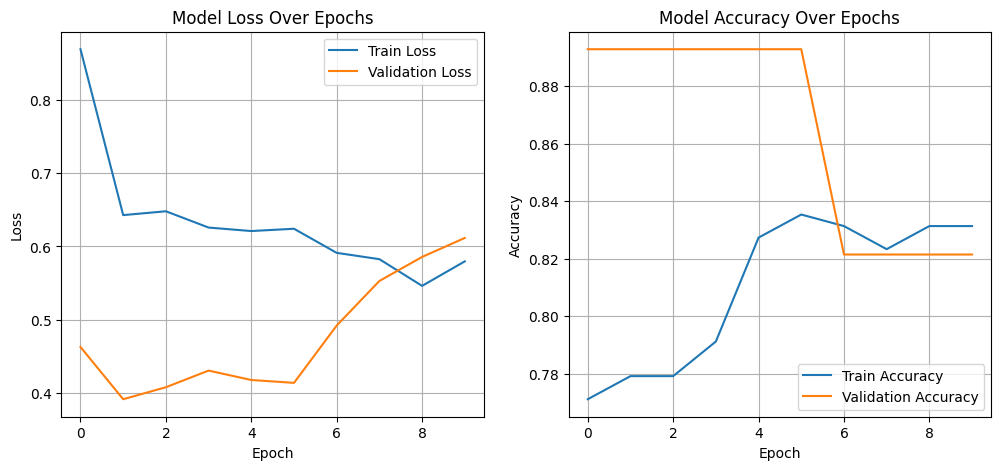

In [9]:
import matplotlib.pyplot as plt

# --- Training History Plot ---
print("--- Plotting Training History ---")

plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
# 🎯 CORRECTED: Using history_lstm instead of history
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
# 🎯 CORRECTED: Using history_lstm instead of history
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

### Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


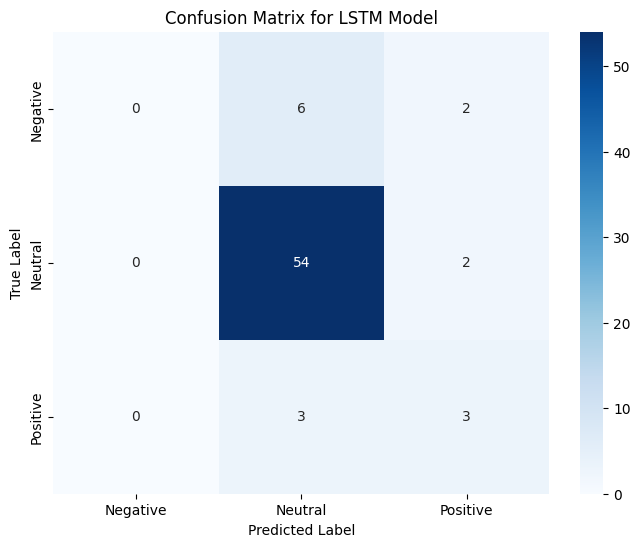


--- Normalized Confusion Matrix (Rows sum to 1.0) ---
This shows the percentage of correct predictions for each True Label.
          Negative   Neutral  Positive
Negative       0.0  0.750000  0.250000
Neutral        0.0  0.964286  0.035714
Positive       0.0  0.500000  0.500000


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# --- 1. Get Predictions ---
# Predict probabilities for the test set
y_pred_probs = lstm_model.predict(X_test)
# Convert probabilities to class labels (0, 1, or 2)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 2. Calculate the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

# --- 3. Visualization ---
# Get the class names in the correct order
class_names = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,          # Show the numbers in the cells
    fmt='d',             # Use integer format
    cmap='Blues',        # Color map
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Confusion Matrix for LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Optional: Print the normalized matrix for precision analysis (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("\n--- Normalized Confusion Matrix (Rows sum to 1.0) ---")
print("This shows the percentage of correct predictions for each True Label.")
print(pd.DataFrame(cm_normalized, index=class_names, columns=class_names))

### A different technique: DeBERTa Model Implementation

### Setup and Tokenization

In [11]:
#!pip install transformers datasets accelerate -U
#!pip install accelerate>=0.21.0
#!pip install scikit-learn
#!pip install torch

In [12]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# --- Configuration ---
# Use the raw 'Text' column for Transformer models
X_raw = df['Text'].tolist()
# Use the encoded 'Label' column
y_labels = df['Label'].tolist()

# Define labels for the model
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

## 1. Train-Validation-Test Split on Raw Data

# Split 1: Separate 80% for train+val, and 20% for final test
X_temp, X_test_raw, y_temp, y_test_raw = train_test_split(
    X_raw, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)

# Split 2: Divide the 80% temp set into 70% train and 10% validation
# (0.125 * 0.8 = 0.1, leaving 0.875 * 0.8 = 0.7 for train)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print(f"Train samples: {len(X_train_raw)}, Validation samples: {len(X_val_raw)}, Test samples: {len(X_test_raw)}")

## 2. Load Tokenizer and Tokenize Data

MODEL_NAME = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # Truncate to 128 tokens for efficiency
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'text': X_train_raw, 'label': y_train_raw})
val_dataset = Dataset.from_dict({'text': X_val_raw, 'label': y_val_raw})
test_dataset = Dataset.from_dict({'text': X_test_raw, 'label': y_test_raw})

# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Select only the columns needed for training (input_ids, attention_mask, label)
tokenized_train = tokenized_train.remove_columns(['text'])
tokenized_val = tokenized_val.remove_columns(['text'])
tokenized_test = tokenized_test.remove_columns(['text'])

Train samples: 242, Validation samples: 35, Test samples: 70


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

### Implement Class Weight

In [13]:
# --- FINAL CORRECTED CUSTOM TRAINER CELL ---

import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer

# 1. Calculate Weights
try:
    y_full = df['Label'].values # Assumes 'df' is available

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_full),
        y=y_full
    )
    weights_tensor = torch.tensor(class_weights, dtype=torch.float)
    print(f"✅ Calculated Class Weights: {class_weights}")

except Exception as e:
    print(f"❌ ERROR calculating weights: {e}")
    weights_tensor = None

# 2. Define Custom Trainer
class CustomTrainer(Trainer):
    # CRITICAL FIX: Added **kwargs to accept unexpected arguments like 'num_items_in_batch'
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        if weights_tensor is None:
             # Fallback to the default unweighted loss
             return super().compute_loss(model, inputs, return_outputs)

        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # Apply the weights to the CrossEntropyLoss function
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

✅ Calculated Class Weights: [2.82113821 0.42060606 3.7311828 ]


### Model Training and Evaluation

In [14]:
# --- CELL 2: MODEL TRAINING AND EVALUATION (Ensure Cell 1 Ran First) ---

from transformers import AutoModelForSequenceClassification, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# NOTE: MODEL_NAME, id2label, label2id, tokenized_train, tokenized_val, and tokenizer
# must be in memory from your previous setup steps.

# --- 1. Load Model ---
# Load the pre-trained DeBERTa model configured for 3 classification classes
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# --- 2. Define Evaluation Metrics ---
def compute_metrics(p):
    """Computes standard classification metrics."""
    preds = np.argmax(p.predictions, axis=1)
    # Weighted metrics are crucial for imbalanced data
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted', zero_division=0)
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# --- 3. Define Training Arguments (OPTIMIZED) ---
training_args = TrainingArguments(
    output_dir="./deberta_results",
    num_train_epochs=5,                          # ⬆️ Increased epochs
    per_device_train_batch_size=8,               # ⬇️ Reduced batch size
    per_device_eval_batch_size=8,                # ⬇️ Reduced batch size
    warmup_steps=100,                            # ⬇️ Reduced warmup steps
    weight_decay=0.01,
    learning_rate=2e-5,                          # ⬇️ CRITICAL: Low learning rate for fine-tuning
    logging_dir='./deberta_logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# --- 4. Initialize Trainer (USES CUSTOMTRAINER) ---
# 🎯 CRITICAL: This uses the CustomTrainer defined in Cell 1 for class weighting
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# --- 5. Start Training ---
print("\n--- Starting Weighted DeBERTa Model Fine-tuning ---")
trainer.train()

# --- 6. Final Evaluation on Test Set ---
print("\n--- Final Evaluation on Unseen Test Set ---")
results = trainer.evaluate(tokenized_test)
print(results)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-641191414.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



--- Starting Weighted DeBERTa Model Fine-tuning ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.110500,1.118298,0.114286,0.023443,0.013061,0.114286
2,1.103800,1.089682,0.114286,0.023443,0.013061,0.114286
3,1.090000,1.014369,0.771429,0.752682,0.736289,0.771429
4,1.044000,0.841435,0.228571,0.132402,0.849725,0.228571
5,0.838400,0.719803,0.828571,0.777143,0.732143,0.828571


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Final Evaluation on Unseen Test Set ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.285470724105835, 'eval_accuracy': 0.7857142857142857, 'eval_f1': 0.7335935467083008, 'eval_precision': 0.7688311688311689, 'eval_recall': 0.7857142857142857, 'eval_runtime': 18.0761, 'eval_samples_per_second': 3.873, 'eval_steps_per_second': 0.498, 'epoch': 5.0}


### Visualization of Training History

--- Plotting DeBERTa Training and Validation Results ---


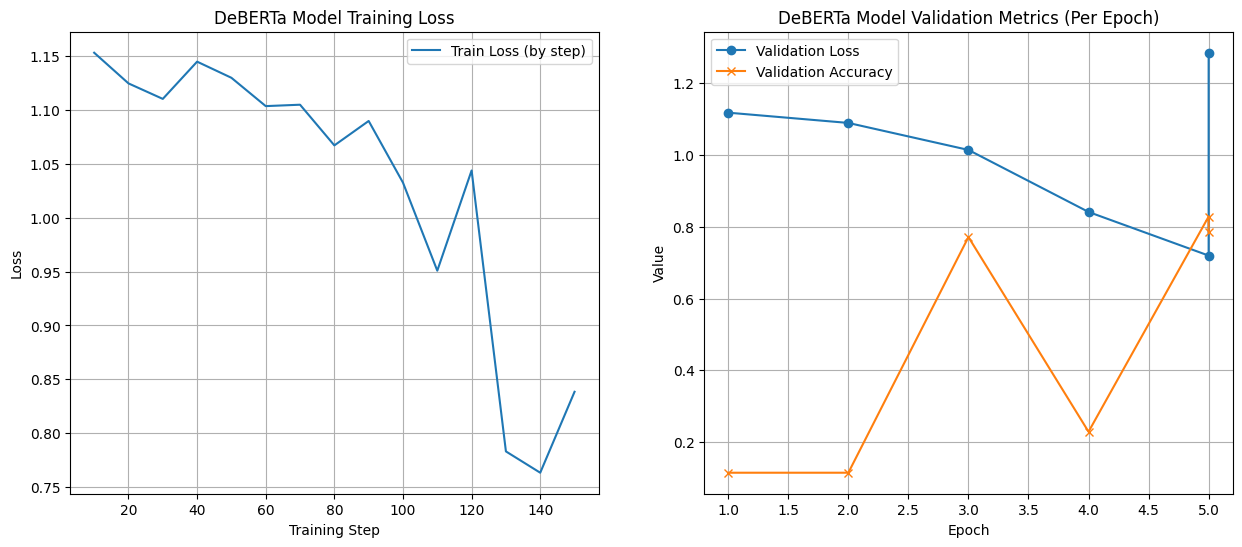

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

print("--- Plotting DeBERTa Training and Validation Results ---")

# The history is stored in the trainer state's log history
log_history = trainer.state.log_history

# Filter the history to get training loss and validation loss/accuracy
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Extract data for plotting
train_loss = [log['loss'] for log in train_logs]
train_steps = [log['step'] for log in train_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]
eval_accuracy = [log['eval_accuracy'] for log in eval_logs]

# Since evaluation happens once per epoch, we use epochs for evaluation plots
eval_epochs = [log['epoch'] for log in eval_logs]

plt.figure(figsize=(15, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss (by step)')
plt.title('DeBERTa Model Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Validation Metrics (by epoch)
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o')
plt.plot(eval_epochs, eval_accuracy, label='Validation Accuracy', marker='x')
plt.title('DeBERTa Model Validation Metrics (Per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()

### Confusion Matrix

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


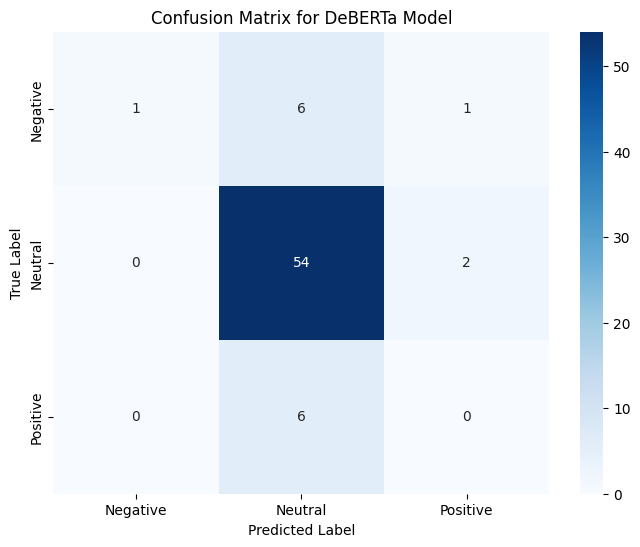


--- Normalized Confusion Matrix (Rows sum to 1.0) ---
This shows the percentage of correct predictions for each True Label.
          Negative   Neutral  Positive
Negative     0.125  0.750000  0.125000
Neutral      0.000  0.964286  0.035714
Positive     0.000  1.000000  0.000000


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# --- 1. Generate Predictions ---
# Use the trainer to predict on the tokenized test dataset
predictions_output = trainer.predict(tokenized_test)

# The predicted labels are the index of the highest logit
y_pred = np.argmax(predictions_output.predictions, axis=1)

# The true labels are already in the tokenized_test dataset
y_true = predictions_output.label_ids

# --- 2. Calculate the Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

# --- 3. Visualization ---
# Get the class names in the correct order (0: Negative, 1: Neutral, 2: Positive)
class_names = list(label2id.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,          # Show the numbers in the cells
    fmt='d',             # Use integer format
    cmap='Blues',        # Color map
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Confusion Matrix for DeBERTa Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Optional: Print the normalized matrix (Row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("\n--- Normalized Confusion Matrix (Rows sum to 1.0) ---")
print("This shows the percentage of correct predictions for each True Label.")
print(pd.DataFrame(cm_normalized, index=class_names, columns=class_names))

### Model Performance Comparison

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import display
# Ensure Keras/TensorFlow is imported if you are using it for lstm_model.predict
# from tensorflow import keras

# --- 1. Prepare LSTM Metrics (CRITICALLY MODIFIED) ---
try:
    print("Attempting LSTM Prediction and Metric Calculation...")

    # 🎯 FIX: Calculate y_pred_lstm explicitly right here
    # Use lstm_model to predict probabilities on the numerical X_test data
    y_pred_probs_lstm = lstm_model.predict(X_test, verbose=0)

    # Convert probabilities to hard class labels (0, 1, or 2)
    y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

    # Calculate the classification report
    report_lstm = classification_report(y_test, y_pred_lstm, output_dict=True, zero_division=0)

    lstm_results = {
        'Accuracy': report_lstm['accuracy'],
        'Weighted F1': report_lstm['weighted avg']['f1-score'],
        'Weighted Precision': report_lstm['weighted avg']['precision'],
        'Weighted Recall': report_lstm['weighted avg']['recall'],
    }
    print("✅ LSTM metrics extracted successfully.")

except NameError as e:
    # Handles if the models or data (e.g., lstm_model, X_test) aren't defined
    print(f"❌ CRITICAL NAME ERROR during LSTM extraction: {e}. Ensure 'lstm_model', 'X_test', and 'y_test' are loaded.")
    lstm_results = {}
except Exception as e:
    # Handles prediction errors (e.g., wrong input shape)
    print(f"❌ CRITICAL EXECUTION ERROR during LSTM prediction: {type(e).__name__}: {e}")
    lstm_results = {}


# --- 2. Prepare DeBERTa Metrics ---
try:
    # This code assumes the 'results' dictionary from the DeBERTa evaluation is in memory
    deberta_results = {
        'Accuracy': results['eval_accuracy'],
        'Weighted F1': results['eval_f1'],
        'Weighted Precision': results['eval_precision'],
        'Weighted Recall': results['eval_recall'],
    }
    print("✅ DeBERTa metrics extracted successfully.")

except NameError:
    print("❌ CRITICAL ERROR: DeBERTa 'results' dictionary is not defined. Run the final DeBERTa evaluation cell.")
    deberta_results = {}


# --- 3. Create Final Comparison DataFrame ---
if lstm_results and deberta_results:
    comparison_df = pd.DataFrame({
        'LSTM (Traditional)': lstm_results,
        'DeBERTa (Transformer)': deberta_results
    }).T

    # Highlight the best score for each metric
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    print("\n--- FINAL MODEL COMPARISON (Side-by-Side) ✅ ---")

    # Display the styled table
    display(comparison_df.style.apply(highlight_max, axis=0).format(precision=4))
else:
    print("\nCannot complete comparison due to missing data from one or both models.")

Attempting LSTM Prediction and Metric Calculation...
✅ LSTM metrics extracted successfully.
✅ DeBERTa metrics extracted successfully.

--- FINAL MODEL COMPARISON (Side-by-Side) ✅ ---


,Accuracy,Weighted F1,Weighted Precision,Weighted Recall
LSTM (Traditional),0.8143,0.7656,0.7224,0.8143
DeBERTa (Transformer),0.7857,0.7336,0.7688,0.7857


### Data Preparation for LSTM Time-Series

In [27]:
# Determine the Data Period (First and Last Day)
print("--- Time-Series Period ---")
print(f"Start Date: {time_series_data.index.min().strftime('%Y-%m-%d')}")
print(f"End Date:   {time_series_data.index.max().strftime('%Y-%m-%d')}")

--- Time-Series Period ---
Start Date: 2009-06-16
End Date:   2025-12-01


In [18]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# --- Configuration (Must Match Training) ---
MODEL_LSTM_PATH = './best_lstm_model.h5'
TOKENIZER_PATH = './lstm_tokenizer.pkl'
MAX_SEQUENCE_LENGTH = 100 # Must be the same value used in padding

# 1. Load the Tokenizer and the LSTM Model
try:
    with open(TOKENIZER_PATH, 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Load the LSTM model
    lstm_model = load_model(MODEL_LSTM_PATH)
    print("✅ LSTM Model and Tokenizer loaded successfully.")

except Exception as e:
    print(f"❌ CRITICAL ERROR loading components: {e}.")
    # If this fails, re-run the saving step!
    raise

# 2. Process the COMPLETE DataFrame (df)
print("Processing all historical data for prediction...")

# A. Convert text to numerical sequences (using the loaded tokenizer)
data_sequences = tokenizer.texts_to_sequences(df['Cleaned_LSTM'].tolist())

# B. Apply the same padding used in training
data_padded = pad_sequences(
    data_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post'
)

print(f"✅ Data ready for prediction. Shape: {data_padded.shape}")

✅ LSTM Model and Tokenizer loaded successfully.
Processing all historical data for prediction...
✅ Data ready for prediction. Shape: (347, 100)


### Sentiment Prediction (Using LSTM)

In [19]:
# 3. Perform Predictions
print("Performing sentiment predictions with LSTM...")

# Predict class probabilities
y_pred_probs = lstm_model.predict(data_padded, batch_size=32, verbose=1)

# Get the predicted class index (0, 1, or 2)
predictions_indices = np.argmax(y_pred_probs, axis=1)

# 4. Map Indices Back to Labels
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"} # Must match your training mapping

df['Predicted_Label'] = [id2label[p] for p in predictions_indices]
df['Predicted_Score'] = predictions_indices # Keep numerical score for aggregation

print(f"✅ Prediction complete. Total classified posts: {len(df)}")

Performing sentiment predictions with LSTM...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
✅ Prediction complete. Total classified posts: 347


### Identify Which Brand Has Bad Comments

In [32]:
# --- 1. Calculate Post-Level Polarity Score ---
# Create a numerical score for each post: +1 for Positive, -1 for Negative, 0 for Neutral
def calculate_polarity(label):
    if label == 'Positive':
        return 1
    elif label == 'Negative':
        return -1
    else: # Neutral
        return 0

df['Polarity_Score'] = df['Predicted_Label'].apply(calculate_polarity)

# --- 2. Aggregate by Brand ---
brand_sentiment_summary = df.groupby('Brand').agg(
    Average_Polarity=('Polarity_Score', 'mean'),
    Total_Posts=('Polarity_Score', 'count')
).sort_values(by='Average_Polarity', ascending=False) # Sort to put the worst sentiment first

print("\n--- Average Sentiment Polarity by Brand (Worst First) ---")
print(brand_sentiment_summary)


--- Average Sentiment Polarity by Brand (Worst First) ---
             Average_Polarity  Total_Posts
Brand                                     
H&M                  0.173333           75
Balenciaga           0.100000           10
Starbucks            0.095890           73
Volkswagen           0.083333           72
Abercrombie          0.021739           46
Nike                 0.014085           71


### Aggregation, Smoothing, and Visualization

In [34]:
print(df.columns.tolist())

['Brand', 'Subreddit', 'Title', 'Review', 'Text', 'Sentiment', 'Cleaned_LSTM', 'Label', 'Predicted_Label', 'Predicted_Score', 'Polarity_Score']


✅ Data aggregation successful. Plotting results...


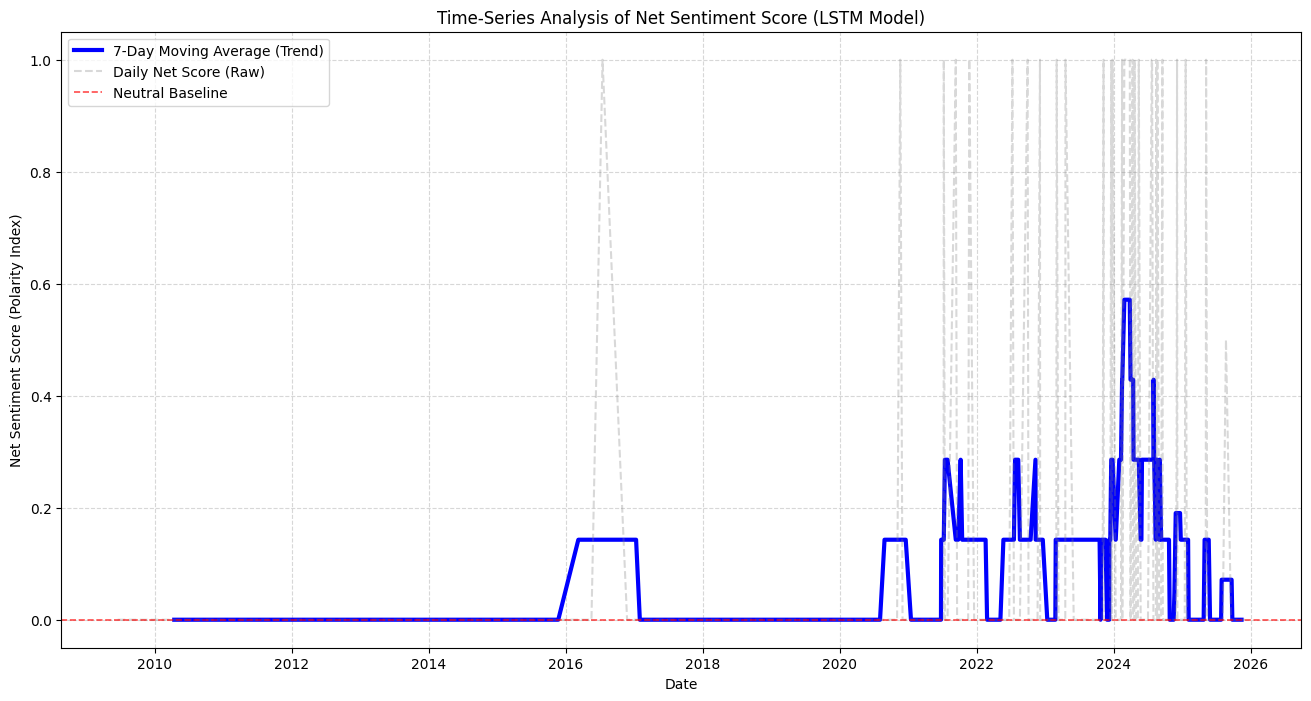

In [35]:
import matplotlib.pyplot as plt

# 1. Ensure the date column is normalized to the day
# 🎯 CRITICAL FIX: Convert the index to DatetimeIndex BEFORE normalizing and grouping.
date_index = pd.to_datetime(df.index).normalize()

# 2. Data Aggregation by Date
# Group the predictions using the correctly converted and normalized date index
time_series_data = df.groupby(date_index)['Predicted_Label'].value_counts().unstack(fill_value=0)

# 3. Calculate the Net Sentiment Score (NSS): (Positive - Negative) / Total
time_series_data['Net_Sentiment_Score'] = (
    time_series_data.get('Positive', 0) - time_series_data.get('Negative', 0)
) / (
    time_series_data.sum(axis=1)
)

# 4. Smooth the Time Series (7-day Moving Average)
time_series_data['Smoothed_Score'] = time_series_data['Net_Sentiment_Score'].rolling(
    window=7,
    center=True
).mean()

print("✅ Data aggregation successful. Plotting results...")

# --- 5. Visualization ---
plt.figure(figsize=(16, 8))


# Plot the smoothed trend (the primary focus for analysis)
plt.plot(time_series_data.index, time_series_data['Smoothed_Score'],
         label='7-Day Moving Average (Trend)', color='blue', linewidth=3)

# Plot the raw daily score (optional background)
plt.plot(time_series_data.index, time_series_data['Net_Sentiment_Score'],
         label='Daily Net Score (Raw)', alpha=0.3, color='grey', linestyle='--')


plt.axhline(0, color='r', linestyle='--', linewidth=1.2, alpha=0.7, label='Neutral Baseline')
plt.title('Time-Series Analysis of Net Sentiment Score (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Net Sentiment Score (Polarity Index)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Imputation Data (For Continuous Trend Analysis or Forecasting)

In [33]:
# Assuming 'time_series_data' is the sparse, aggregated DataFrame created in Step 3 (before the error).
print("--- Creating Continuous Time-Series for Crisis Detection ---")

# 1. Define the full range of dates from the start to the end of your data
full_date_range = pd.date_range(
    start=time_series_data.index.min(),
    end=time_series_data.index.max(),
    freq='D'
)

# 2. Re-index the sparse data to the full date range and fill missing scores with 0.0
time_series_continuous = time_series_data.reindex(full_date_range).fillna(0.0)

# 3. Recalculate the Smoothed Score on the continuous data
time_series_continuous['Smoothed_Score_Continuous'] = time_series_continuous['Net_Sentiment_Score'].rolling(
    window=7,
    center=True
).mean()

print("✅ Continuous time-series created. Ready for visualization.")

--- Creating Continuous Time-Series for Crisis Detection ---
✅ Continuous time-series created. Ready for visualization.


In [36]:
print("\n--- Daily Net Sentiment Score Sample ---")
# Display the last 15 days of the analysis
print(time_series_data[['Net_Sentiment_Score', 'Smoothed_Score']].tail(15))


--- Daily Net Sentiment Score Sample ---
Predicted_Label  Net_Sentiment_Score  Smoothed_Score
Datetime                                            
2025-07-30                       0.0        0.071429
2025-07-31                       0.0        0.071429
2025-08-05                       0.0        0.071429
2025-08-22                       0.5        0.071429
2025-09-18                       0.0        0.071429
2025-09-20                       0.0        0.071429
2025-09-21                       0.0        0.071429
2025-09-25                       0.0        0.000000
2025-09-29                       0.0        0.000000
2025-11-04                       0.0        0.000000
2025-11-05                       0.0        0.000000
2025-11-13                       0.0        0.000000
2025-11-25                       0.0             NaN
2025-11-27                       0.0             NaN
2025-12-01                       0.0             NaN


### Final Visualization: Continuous Time-Series Plot

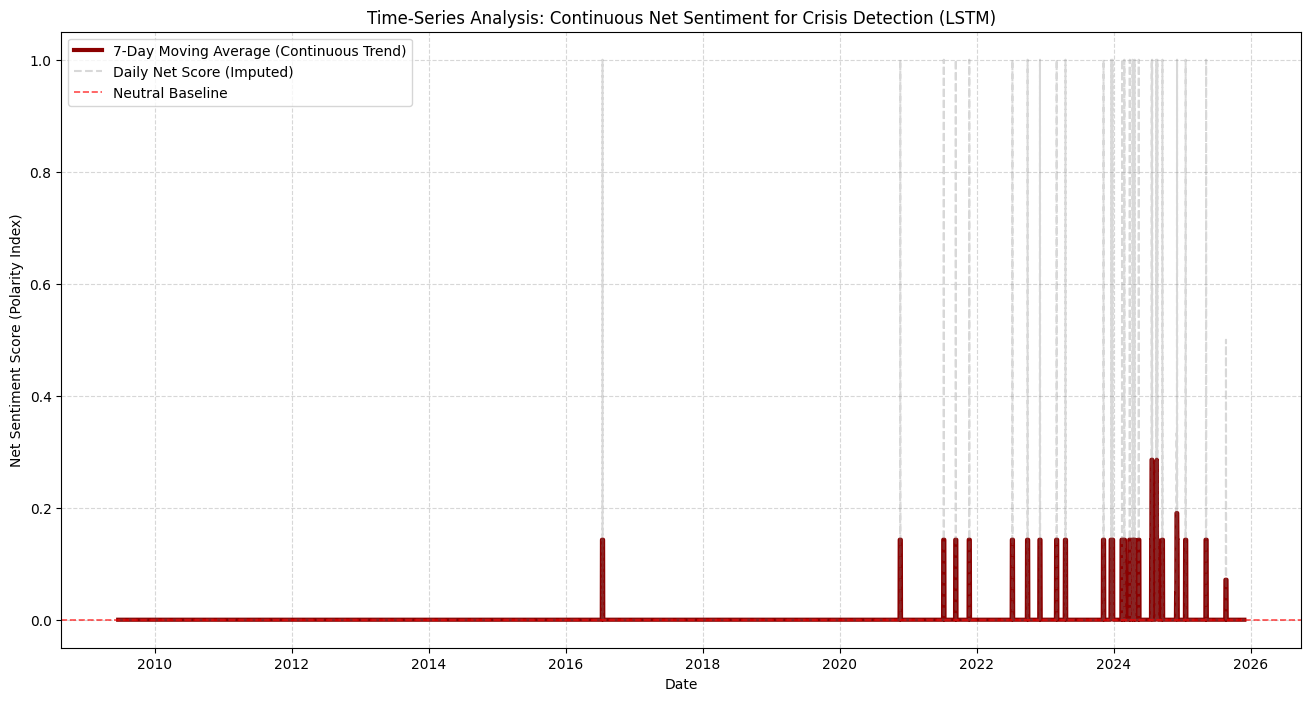

In [37]:
import matplotlib.pyplot as plt

# --- Visualization using Continuous Data ---
plt.figure(figsize=(16, 8))


# Plot the smoothed trend (the primary focus for crisis detection)
# We use the Smoothed_Score_Continuous column from the imputed data.
plt.plot(time_series_continuous.index, time_series_continuous['Smoothed_Score_Continuous'],
         label='7-Day Moving Average (Continuous Trend)', color='darkred', linewidth=3)

# Plot the raw daily score (now using the imputed data, which filled gaps with 0.0)
plt.plot(time_series_continuous.index, time_series_continuous['Net_Sentiment_Score'],
         label='Daily Net Score (Imputed)', alpha=0.3, color='grey', linestyle='--')


plt.axhline(0, color='r', linestyle='--', linewidth=1.2, alpha=0.7, label='Neutral Baseline')
plt.title('Time-Series Analysis: Continuous Net Sentiment for Crisis Detection (LSTM)')
plt.xlabel('Date')
plt.ylabel('Net Sentiment Score (Polarity Index)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Reference:
